In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
TEST = False
START = pd.to_datetime('2008-01-01')

In [4]:
sp = pd.read_csv('../data/sp1950.csv')
sp = sp[['Date', 'Open', 'Close', 'Adj Close']]
sp = sp.rename(columns={'Adj Close': 'Value'})
sp.head()

,Date,Open,Close,Value
0,1/3/50,16.66,16.66,16.66
1,1/4/50,16.85,16.85,16.85
2,1/5/50,16.93,16.93,16.93
3,1/6/50,16.98,16.98,16.98
4,1/9/50,17.08,17.08,17.08


In [5]:
def date2datetime(date):
    month, day, year = date.split('/')
    if int(year) > 20:
        year = int(year) + 1900
    else:
        year = int(year) + 2000
    try:
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        print(date)

In [6]:
sp.Date = sp.Date.apply(date2datetime)
sp.head()
if TEST:
    sp = sp.loc[sp.Date >= START, :]
    sp.index = range(sp.shape[0])
sp.head()

,Date,Open,Close,Value
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


In [7]:
def get_n_day_returns(n, sp):
    N = sp.shape[0]
    last_value = N - n
    s1 = sp.Close[:last_value]
    s2 = sp.Close[n:]
    s2.index = range(len(s2))
    returns = s2 / s1
    returns = returns.append(pd.Series([np.nan] * n))
    returns.index = range(len(returns))
    return returns

In [66]:
returns20 = get_n_day_returns(20, sp)
returns60 = get_n_day_returns(60, sp)
returns125 = get_n_day_returns(125, sp)
returns250 = get_n_day_returns(250, sp)

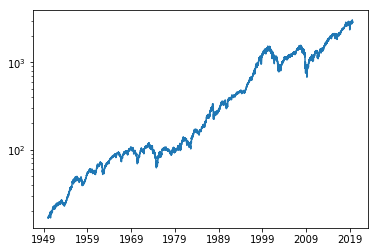

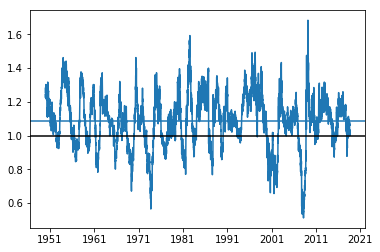

In [9]:
plt.plot(sp.Date, sp.Close);
plt.yscale('log')
plt.figure();
plt.plot(sp.Date, returns250, label='250');
plt.axhline(y=1, color='k');
plt.axhline(y=returns250.mean());

In [67]:
sp['returns_1yr'] = returns250
sp['returns_6mo'] = returns125
sp['returns_3mo'] = returns60
sp['returns_1mo'] = returns20
sp.head()

,Date,Open,Close,Value,returns_1yr,returns_6mo,returns_3mo,returns_1mo
0,1950-01-03,16.66,16.66,16.66,1.241897,1.058823,1.038415,1.023409
1,1950-01-04,16.85,16.85,16.85,1.238576,1.056973,1.026113,1.011869
2,1950-01-05,16.93,16.93,16.93,1.232723,1.057885,1.035440,1.017720
3,1950-01-06,16.98,16.98,16.98,1.236749,1.040636,1.033569,1.018257
4,1950-01-09,17.08,17.08,17.08,1.236534,1.029859,1.032201,1.014052


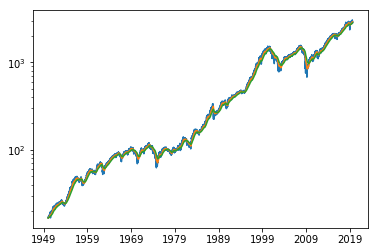

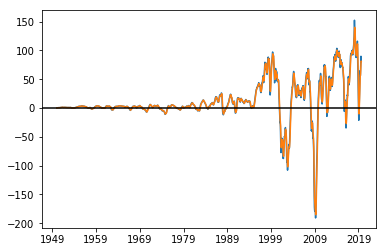

In [11]:
plt.plot(sp.Date, sp.Close);
EMA90 = sp.Close.ewm(
    span=90, min_periods=0, adjust=False, ignore_na=False).mean()
EMA250 = sp.Close.ewm(
    span=250, min_periods=0, adjust=False, ignore_na=False).mean()
plt.plot(sp.Date, EMA90)
plt.plot(sp.Date, EMA250)
plt.yscale('log');
plt.figure()
macd = EMA90 - EMA250
smoothed = macd.ewm(
    span=30, min_periods=0, adjust=False, ignore_na=False).mean()
plt.plot(sp.Date, macd)
plt.plot(sp.Date, smoothed)
plt.axhline(y=0, color='k');

In [12]:
def get_macd(series, fast, slow, smooth):
    f = series.ewm(
        span=fast, min_periods=0, adjust=False, ignore_na=False).mean()
    s = series.ewm(
        span=slow, min_periods=0, adjust=False, ignore_na=False).mean()
    d = f - s
    sm = d.ewm(
        span=smooth, min_periods=0, adjust=False, ignore_na=False).mean()
    return sm

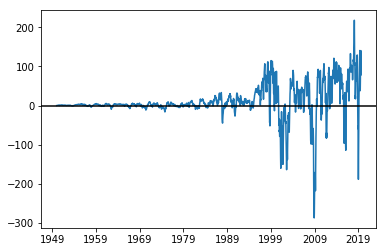

In [13]:
macd10_151_14 = get_macd(sp.Close, 10, 151, 14)
plt.plot(sp.Date, macd10_151_14)
plt.axhline(y=0, color='k');

0.020069667894936062


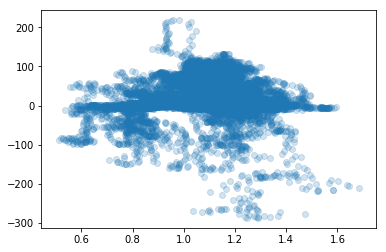

In [14]:
print(macd10_151_14.corr(sp.returns_1yr))
plt.scatter(sp.returns_1yr, macd10_151_14, alpha=0.2);

In [184]:
macd10_151_14.diff().corr(sp.returns_1yr)

0.004153403936817082

In [70]:
def get_macd_cor(fast, slow, smooth, sp, returns):
    macd = get_macd(sp.Close, fast, slow, smooth)
    return macd.corr(returns)

In [72]:
get_macd_cor(10, 151, 14, sp, sp.returns_1yr)

0.020069667894936062

In [76]:
def search_best_macd_unif(sp, returns, best=0, iters=100):
    for i in range(iters):
        fast = int(np.random.uniform(5, 90))
        slow = int(np.random.uniform(fast, 2500))
        cor = get_macd_cor(fast, slow, 14, sp, returns)
        if np.abs(cor) > np.abs(best):
            best = cor
            print(f'New Best: macd({fast}, {slow}, 14): {cor:.5f}')

In [77]:
search_best_macd_unif(sp, sp.returns_1yr)

New Best: macd(68, 704, 14): -0.07200
New Best: macd(63, 1175, 14): -0.09596
New Best: macd(72, 1364, 14): -0.10348
New Best: macd(6, 2207, 14): -0.10905
New Best: macd(79, 2347, 14): -0.12098


In [75]:
search_best_macd(sp, sp.returns_1yr, best=-0.12330, iters=1000)

In [25]:
search_best_macd(sp, best=-0.12337, iters=1000)

In [79]:
def search_best_macd_norm(
        sp, returns, best_fast, best_slow, sd_fast, sd_slow, best=0, iters=100):
    for i in range(iters):
        fast = max(int(np.random.normal(best_fast, sd_fast)), 5)
        slow = max(int(np.random.uniform(best_slow, sd_slow)), 20)
        cor = get_macd_cor(fast, slow, 14, sp, returns)
        if np.abs(cor) > np.abs(best):
            best = cor
            print(f'New Best: macd({fast}, {slow}, 14): {cor:.8f}')

In [84]:
search_best_macd_norm(sp, 
                      sp.returns_1yr,
                      best_fast=599, 
                      best_slow=2605, 
                      sd_fast=40, 
                      sd_slow=160, 
                      best=-0.14193181,
                      iters=1000)

New Best: macd(602, 2601, 14): -0.14193213


In [88]:
search_best_macd_norm(sp, 
                      sp.returns_1yr,
                      best_fast=602, 
                      best_slow=2601, 
                      sd_fast=10, 
                      sd_slow=40, 
                      best=-0.14193213,
                      iters=1000)

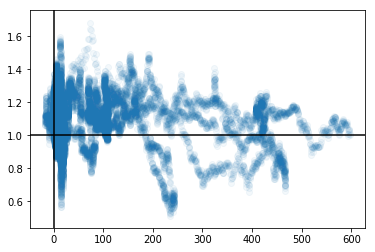

In [89]:
plt.scatter(get_macd(sp.Close, 602, 2601, 14), sp.returns_1yr, alpha=0.05);
plt.axhline(y=1, color='k');
plt.axvline(x=0, color='k');

In [90]:
macd_602_2601_14 = get_macd(sp.Close, 602, 2601, 14)
macd_602_2601_14.quantile(q=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

0.01     -9.527561
0.05      0.664340
0.10      3.724567
0.90    373.887213
0.95    439.679907
0.99    610.202933
Name: Close, dtype: float64

In [91]:
sp['macd_602_2601_14_1yr'] = macd_602_2601_14

In [98]:
search_best_macd_unif(sp, sp.returns_6mo, best=-0.07770, iters=1000)

New Best: macd(88, 2499, 14): -0.07785
New Best: macd(89, 2497, 14): -0.07793


In [101]:
search_best_macd_unif(sp, sp.returns_6mo, best=-0.07793, iters=1000)

In [113]:
search_best_macd_norm(sp, 
                      sp.returns_6mo,
                      best_fast=1659, 
                      best_slow=1675, 
                      sd_fast=100, 
                      sd_slow=100, 
                      best=-0.09903647,
                      iters=1000)

New Best: macd(1664, 1670, 14): -0.09903648


In [116]:
search_best_macd_norm(sp, 
                      sp.returns_6mo,
                      best_fast=1664, 
                      best_slow=1670, 
                      sd_fast=60, 
                      sd_slow=60, 
                      best=-0.09903648,
                      iters=1000)

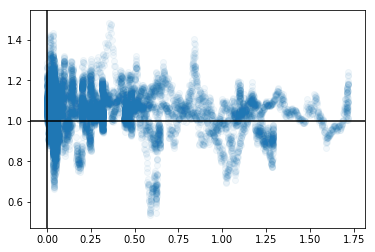

In [117]:
plt.scatter(get_macd(sp.Close, 1664, 1670, 14), sp.returns_6mo, alpha=0.05);
plt.axhline(y=1, color='k');
plt.axvline(x=0, color='k');

In [118]:
macd_1664_1670_14 = get_macd(sp.Close, 1664, 1670, 14)
sp['macd_1664_1670_14_6mo'] = macd_1664_1670_14

In [121]:
search_best_macd_unif(sp, sp.returns_3mo, best=-0.04736, iters=1000)

New Best: macd(89, 2476, 14): -0.04739


In [122]:
search_best_macd_unif(sp, sp.returns_3mo, best=-0.04739, iters=1000)

In [154]:
search_best_macd_norm(sp, 
                      sp.returns_3mo,
                      best_fast=1829, 
                      best_slow=1876, 
                      sd_fast=100, 
                      sd_slow=100, 
                      best=-0.06853091,
                      iters=1000)

New Best: macd(1866, 1843, 14): 0.06853111
New Best: macd(1845, 1853, 14): -0.06853125


In [158]:
search_best_macd_norm(sp, 
                      sp.returns_3mo,
                      best_fast=1845, 
                      best_slow=1853, 
                      sd_fast=40, 
                      sd_slow=40, 
                      best=-0.06853125,
                      iters=1000)

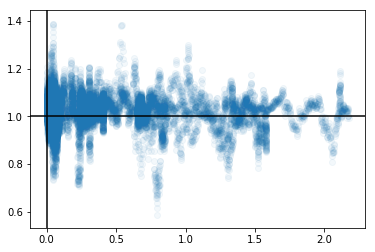

In [159]:
plt.scatter(get_macd(sp.Close, 1845, 1853, 14), sp.returns_3mo, alpha=0.05);
plt.axhline(y=1, color='k');
plt.axvline(x=0, color='k');

In [160]:
macd_1845_1853_14 = get_macd(sp.Close, 1845, 1853, 14)
sp['macd_1845_1853_14_3mo'] = macd_1845_1853_14

In [177]:
search_best_macd_norm(sp, 
                      sp.returns_1mo,
                      best_fast=1940, 
                      best_slow=1943, 
                      sd_fast=100, 
                      sd_slow=100, 
                      best=-0.03692015,
                      iters=1000)

New Best: macd(1937, 1941, 14): -0.03692018


In [181]:
search_best_macd_norm(sp, 
                      sp.returns_1mo,
                      best_fast=1937, 
                      best_slow=1941, 
                      sd_fast=40, 
                      sd_slow=40, 
                      best=-0.03692018,
                      iters=1000)

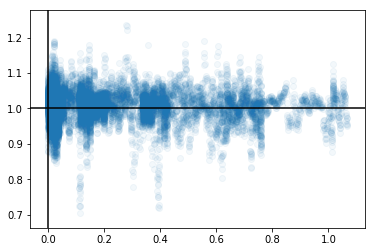

In [182]:
plt.scatter(get_macd(sp.Close, 1937, 1941, 14), sp.returns_1mo, alpha=0.05);
plt.axhline(y=1, color='k');
plt.axvline(x=0, color='k');